# 📺 Denoise a map with custom inputs

This notebook takes you step by step through the same procedure as used by `meteor.diffmap`, but in a notebook. There is one difference: we assume you've got some pre-computed phases that you want to employ, rather than computing phases from a structural model (CIF/PDB).

In [4]:
# ruff: noqa: T201

import numpy as np
import reciprocalspaceship as rs
from matplotlib import pyplot as plt

from meteor.diffmaps import compute_difference_map, max_negentropy_kweighted_difference_map
from meteor.rsmap import Map
from meteor.tv import tv_denoise_difference_map
from meteor.validate import map_negentropy

### 1. Load the data of interest

We'll use `scaled-test-data.mtz`, an test/example MTZ provided in this repo. The data come from a real experiment, Fadini _et al._ (**2023**) _J Am Chem Soc_ 145: 15796-15808 (https://doi.org/10.1021/jacs.3c02313), where the authors imaged the cis-trans isomerization of rsEGFP2. The MTZ contains a lot of columns -- we'll ignore most of them and focus on.

- the amplitudes and phases for a dark reference dataset
- amplitudes for a light-activated dataset

In [18]:
# path is relative to where this notebook usually is in the `meteor` repo
folder_location = "../meteor/test/data/"
mtz_path = folder_location+"scaled-test-data.mtz"
mtz_dataset = rs.read_mtz(mtz_path)

print(mtz_dataset.columns)
mtz_dataset

Index(['F_on', 'SIGF_on', 'F_off', 'SIGF_off', 'FC_nochrom', 'PHIC_nochrom',
       'F_on_scaled', 'SIGF_on_scaled', 'F_off_scaled', 'SIGF_off_scaled',
       'F_k', 'SIGF_k', 'PHI_k', 'F_TV', 'PHI_TV', 'SIGF_TV', 'F_itTV',
       'SIGF_itTV', 'PHI_itTV'],
      dtype='object')


F_on   SIGF_on      F_off  SIGF_off  FC_nochrom  PHIC_nochrom  \
H  K  L                                                                        
0  0  4    8.011057  0.863579   9.283087  0.958057  240.917175    180.000015   
      6   30.975687  2.312218  25.823608  2.077911  502.529755    180.000015   
      8   18.505907  2.773533  15.957798  2.617453  524.541382    180.000015   
      10  38.632221  3.155106  29.471071  2.552977   439.58493         360.0   
      12  21.541544  1.861844  22.385498   2.05849  244.351562    180.000015   
...             ...       ...        ...       ...         ...           ...   
34 11 6    1.802522   0.96382   1.840262  0.896258     6.59658      7.132044   
   12 2    1.040703  0.618049   1.062676   0.64162   10.618246    188.407745   
      5    1.585076  0.736849   2.405357   0.94527   12.357416    305.263458   
35 2  0    1.318665  0.889595   7.111948  0.861651   15.280899     90.000008   
      4    1.023447  0.704058   3.919934  1.295623   18.458782     92.787331   

          F_on_scaled  SIGF_on_scaled  F_off_scaled  SIGF_off_scaled  \
H  K  L                                                                
0  0  4    111.721573       12.043403    135.138657        13.946932   
      6    428.997192       32.023022    373.048096        30.017523   
      8    253.819321       38.040627    228.058289        37.406898   
      10   523.286194       42.736958    415.391968        35.983963   
      12   287.366577       24.837204    310.229065        28.527554   
...               ...             ...           ...              ...   
34 11 6      5.810488        3.106906      6.047815         2.945451   
   12 2      3.347993        1.988295      3.460584         2.089425   
      5      5.068055         2.35597      7.827047         3.075915   
35 2  0      4.120879        2.780018     22.406181         2.714631   
      4      3.193046        2.196586     12.406024          4.10046   

                F_k    SIGF_k       PHI_k      F_TV      PHI_TV   SIGF_TV  \
H  K  L                                                                     
0  0  4     4.29962  3.383419    0.000019  4.104198  359.827698  3.383419   
      6    2.132432  1.672898 -179.999985  1.889815  178.712463  1.672898   
      8     0.71406  1.478825 -179.999985  0.519908  186.646011  1.478825   
      10   2.368493  1.226426     0.00001  1.419956  359.240112  1.226426   
      12     1.2202  2.018752    0.000019  0.446494    3.752057  2.018752   
...             ...       ...         ...       ...         ...       ...   
34 11 6    0.193971  3.499082  -172.86795  0.021647  193.223831  3.499082   
   12 2    0.102222  2.618628    8.407731  0.010754   56.616051  2.618628   
      5    2.323771  3.263322  125.263443  0.130234   59.822773  3.263322   
35 2  0   13.340703  2.834864  -89.999992  1.054792   283.01886  2.834864   
      4    7.026342  3.547688  -87.212669  0.735626  268.623535  3.547688   

            F_itTV  SIGF_itTV    PHI_itTV  
H  K  L                                    
0  0  4   4.263433   3.368434  345.693268  
      6   1.914395   1.671889  185.970078  
      8   0.537505   1.478361  201.736832  
      10  1.464422   1.226652  355.365723  
      12  0.430938    2.01839  350.278625  
...            ...        ...         ...  
34 11 6   0.031937   3.499079  216.712357  
   12 2     0.0155   2.618614  352.686859  
      5   0.132257   3.263343   46.157078  
35 2  0   1.069749   2.835721  282.667603  
      4   0.776384   3.547976  267.622711  

[41429 rows x 19 columns]

We'll use the same phase column for both the `native` and `derivative` datasets we're comparing, making the maps we compute isomorphous difference maps. Note that's not a requirement, though!

In this case, the phases were computed _omitting_ the chromophore where isomerization was expected, so the results should not be biased by the starting model at all. This is a nice application of a custom phase calculation. But: the same effect could be achieved by passing a model without the chromophore to `meteor.diffmap` 😊.

In [6]:
native_map = Map(
    mtz_dataset,
    amplitude_column="F_off",
    phase_column="PHIC_nochrom",
    uncertainty_column="SIGF_off",
)

derivative_map = Map(
    mtz_dataset,
    amplitude_column="F_on",
    phase_column="PHIC_nochrom",
    uncertainty_column="SIGF_on",
)

In [7]:
# for a reference, let's compute a "vanilla" difference map to benchmark the initial negentropy
vanilla_isomorphous_diffmap = compute_difference_map(derivative_map, native_map)
initial_negentropy = map_negentropy(vanilla_isomorphous_diffmap)

print(f"initial negentropy: {initial_negentropy:.5f}")

initial negentropy: 0.00114


### 2. Compute a _k_-weighted difference map

Now, we'll compute a _k_-weighted difference map, varying the _k_-parameter to maximize the difference map negentropy.

In [8]:
k_weighted_diffmap, kparameter_metadata = max_negentropy_kweighted_difference_map(
    derivative_map, native_map
)
kewighted_negentropy = map_negentropy(k_weighted_diffmap)

print(f"optimal k-parameter: {kparameter_metadata.optimal_parameter_value}")
print(f"negentropy: {kewighted_negentropy:.5f}")

optimal k-parameter: 0.01
negentropy: 0.00127


### 3. TV denoise the map

Finally, the main event, the entreé! Let's improve our _k_-weighted map by TV-denoising it.

In [9]:
tv_denoised_map, metadata = tv_denoise_difference_map(k_weighted_diffmap, full_output=True)

We can inspect the run `metadata` to observe the optimization in progress -- the Golden section method should nicely sample the region around the maximum more densely.

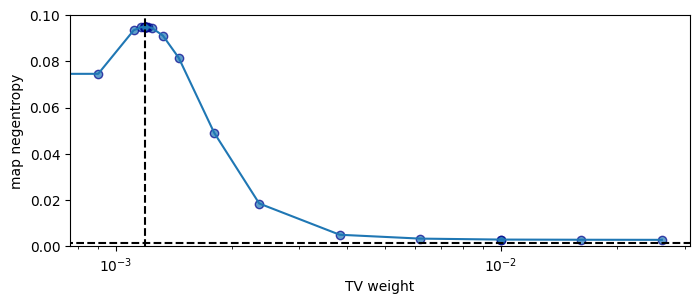

In [10]:
plt.figure(figsize=(8, 3))

plt.xlabel("TV weight")
plt.ylabel("map negentropy")
plt.xscale("log")

# points are not sampled in order of increasing TV weight, so we have to order them
tv_weights_scanned = [pt.parameter_value for pt in metadata.parameter_scan_results]
negentropy_at_weights = [pt.objective_value for pt in metadata.parameter_scan_results]
sort_order = np.argsort(tv_weights_scanned)

plt.plot(
    np.array(tv_weights_scanned)[sort_order],
    np.array(negentropy_at_weights)[sort_order],
)

plt.scatter(
    tv_weights_scanned,
    negentropy_at_weights,
    edgecolors="darkblue",
    linewidths=1,
    alpha=0.7,
)

plt.hlines(metadata.initial_negentropy, 0, 0.05, color="black", linestyle="dashed")
plt.vlines(metadata.optimal_parameter_value, -0.01, 0.10, color="black", linestyle="dashed")
plt.ylim([0, 0.10])

plt.show()

### 4. Write out the results

Awesome! Now we have a fancy new diffmap, which we probably want to save so we can do something with it. Like fire up Coot and check it out. If you are curious, the PDB ID corresponding to this dataset is `8a6g`, and you can find a copy of the structure as a PDB file in this repository:

> `../test/data/8a6g.pdb`

In [11]:
# tv_denoised_map.write_mtz("my_denoised_diffmap.mtz")

In [1]:
from plotting3d import *

In [12]:
# def slice_3d(mtzdata, gif_name="", extent=None, startval=10, is_diff=False):
#     xlen, ylen, zlen = mtzdata.shape
#     xline = np.linspace(0, 1, xlen)
#     fig = plt.figure(figsize=(7, 6))
#     ax = fig.add_subplot()
#     ax.set_title(xline[0])
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
#     extent = [1, 0, 0, 1] if extent is None else extent
#     if is_diff:
#         vmax = np.max(np.abs(mtzdata))
#         imkwargs = {"cmap": "bwr",  "vmax":vmax, "vmin":-vmax}
#     else:
#         imkwargs ={}
#     im = plt.imshow(mtzdata[startval], extent=extent, **imkwargs)
#     ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
#     @widgets.interact(f0=(0, len(xline) - 1, 1))
#     def update(f0=0):
#         im.set_data(mtzdata[f0])
#         ax.set_title(f"z={xline[f0]:.3f}")

#     if gif_name != "":
#         anim = animation.FuncAnimation(fig, update, frames=len(xline), interval=500)
#         anim.save(gif_name)
#         plt.show()
#         return anim

In [13]:
tv_denoised=rs.DataSet(tv_denoised_map)
tv_denoised["sf"] = tv_denoised.to_structurefactor("F","PHI")
tv_denoised_grid = tv_denoised.to_reciprocal_grid("sf")
tv_denoised_real = np.fft.ifftn(tv_denoised_grid)


interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

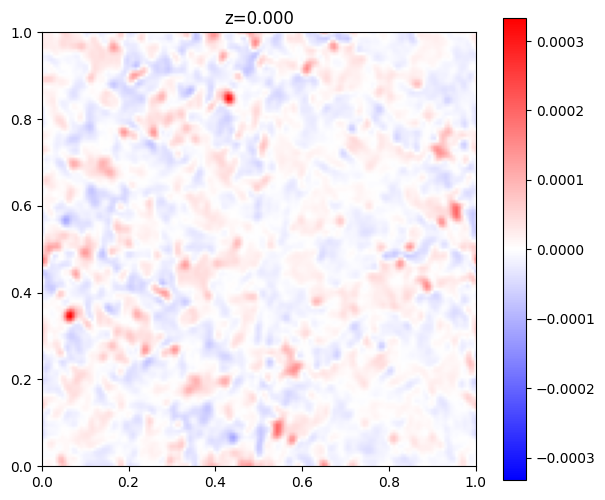

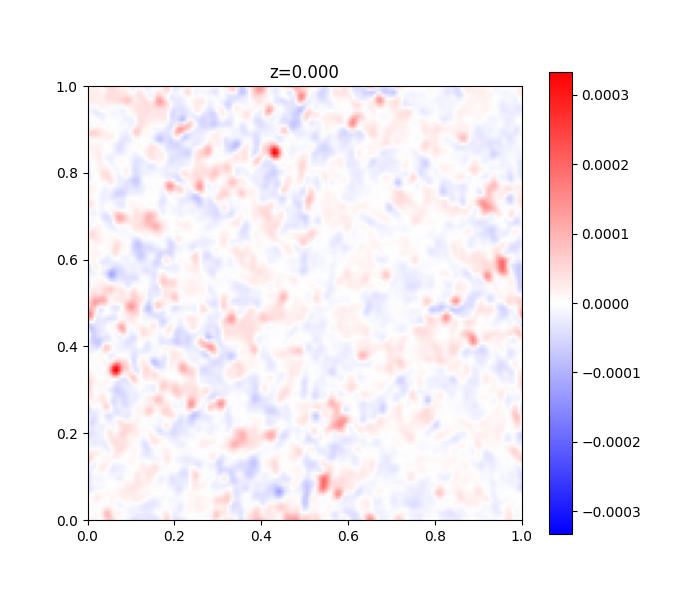

In [14]:
%matplotlib widget
imkwargs={"cmap":"bwr"}
slice_3d(tv_denoised_real.real, is_diff=True)

interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

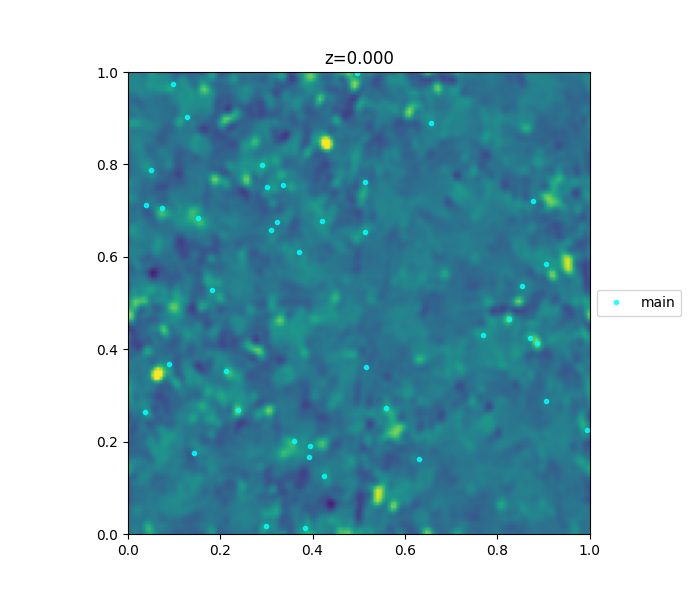

In [22]:
dataloc = "../synthetic_cistrans/"
pdbname_light = dataloc+"100ps.pdb"
pdbname_light = folder_location+"8a6g-chromophore-removed.pdb"
struc_light = gemmi.read_structure(pdbname_light)
pdbname_dark = folder_location+"8a6g-chromophore-removed.pdb"
struc_dark = gemmi.read_structure(pdbname_dark)
%matplotlib widget
pos_list = np.array([(rca.atom.pos).tolist()   for rca in struc_light[0].all()])
for idx in range(3):
    diff = np.max(pos_list[:,idx])-np.min(pos_list[:,idx])
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
# np.flip(obj1-obj0,(0,1,2))
tv_real = tv_denoised_real.real
tv_real = np.flip(tv_real,(0,1,2))
_ = mtz_comp(frac_list,occ_mask, tv_real[::-1] ,extent=[0,1,1,0],) 


interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

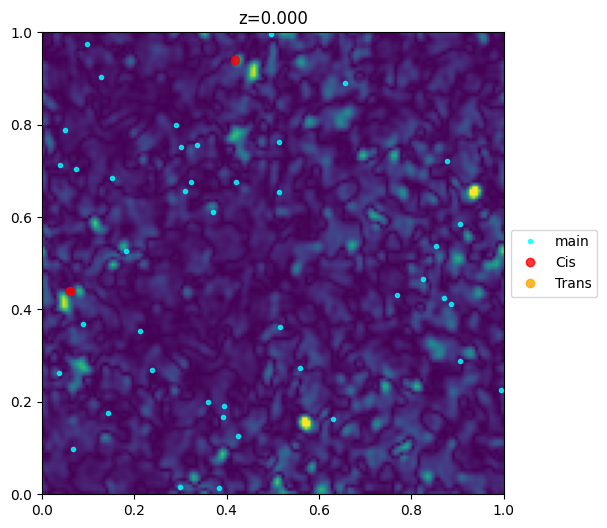

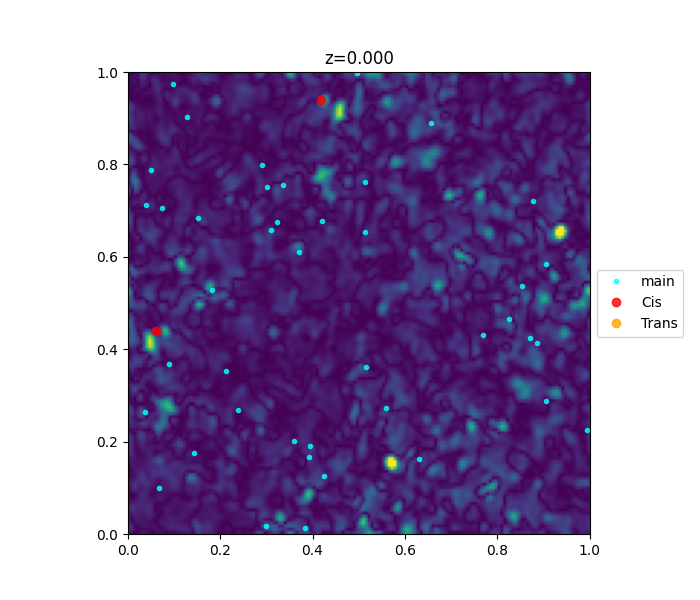

In [16]:
def blockwise_average_ND(a, factors):    
    """
    `a` is the N-dim input array
    `factors` is the blocksize on which averaging is to be performed
    """

    factors = np.asanyarray(factors)
    sh = np.column_stack([a.shape//factors, factors]).ravel()
    b = a.reshape(sh).mean(tuple(range(1, 2*a.ndim, 2)))

    return b

tv_real = tv_denoised_real.real
# tv_real = np.flip(tv_real,(0,1,2))
# tv_real_reduce = blockwise_average_ND(tv_real, [2,2,2])
tv_real_tile = np.tile(tv_real,(2,2,2))

mtz_comp(frac_list,occ_mask, np.abs(tv_real) ,extent=[0,1,1,0]) 


In [17]:
out = make_blurred(frac_list[occ_mask>0],tv_real_reduce.shape, radius=0.1)
np.max(tv_real)

NameError: name 'make_blurred' is not defined

In [ ]:
from scipy import stats
def make_blurred(frac_pos, grid_shape,radius= .01):
    frac_pos = frac_pos.T
    X, Y, Z = np.mgrid[
        0 : 1 : grid_shape[0] * 1j,
        0 : 1 : grid_shape[1] * 1j,
        0 : 1 : grid_shape[2] * 1j,
    ]
    grid = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

    kernel = stats.gaussian_kde(frac_pos, radius)
    density = np.reshape(kernel(grid).T, X.shape)
    return density
out = make_blurred(frac_list[occ_mask>0],tv_real_reduce.shape, radius=0.1)



In [ ]:
from scipy import signal
def cross_corr(test_img, truth_img):
    corr_size = max(np.size(test_img), np.size(truth_img))
    corr2 = (
        signal.correlate(
            test_img - np.mean(test_img), truth_img - np.mean(truth_img), mode="valid"
        )
        / corr_size
        / np.std(truth_img)
        / np.std(test_img)
    )
    idcs = tuple(np.array(np.zeros(corr2.ndim), dtype=int))
    idx = np.array(np.unravel_index(corr2.argmax(), corr2.shape))
    if corr2.size == 1:
        return corr2[idcs]
    return corr2, idx

cc = cross_corr(np.abs(tv_real_tile),out)
np.max(cc[0])

In [ ]:
slc1 = slice(None,None,1)
slc2 = slice(None,None,-1)
slcs = [slc1,slc2]
for x, slc_x in enumerate(slcs):
    for y, slc_y in enumerate(slcs):
        for z, slc_z in enumerate(slcs):
                cc, idx = cross_corr(np.abs(tv_real_tile),out[)
                
np.arange(9).reshape(3,3)[slc1,slc2]